In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook

In [2]:
n = str(2) #chiller number
df = pd.read_csv("data/Chiller"+n+"_full.csv")
df.index = pd.to_datetime(df['ts'])
df.drop('ts', axis=1, inplace=True)
df.head()

,ch1Watt,ch2Watt,ch3Watt,value1,value2,value3,value4,conflowRate,conflowSpeed,evaflowRate,evaflowSpeed
ts,,,,,,,,,,,
2017-05-01 00:00:00,325.0,0.0,324.0,18.580934,21.582337,23.633118,23.451539,0.0,0.0,0.0,0.0
2017-05-01 00:01:00,326.0,0.0,328.0,18.602295,21.539612,23.558351,23.398133,0.0,0.0,0.0,0.0
2017-05-01 00:02:00,327.0,0.0,324.0,18.495484,21.614379,23.483581,23.323363,0.0,0.0,0.0,0.0
2017-05-01 00:03:00,338.0,0.0,325.0,18.474123,21.571657,23.601076,23.205871,0.0,0.0,0.0,0.0
2017-05-01 00:04:00,334.0,0.0,328.0,18.559570,21.560973,23.536987,23.227236,0.0,0.0,0.0,0.0


In [3]:
df['deltaT12'] = df['value2']-df['value1']
df['deltaT34'] = df['value4']-df['value3']
df['totalWatt'] = df.apply(lambda row: row['ch1Watt']+row['ch2Watt']+row['ch3Watt'], axis=1)
df.drop(['ch1Watt', 'ch2Watt', 'ch3Watt'], inplace=True, axis=1)
df=df[['value1','value3','conflowRate','evaflowRate','deltaT12','deltaT34','totalWatt']]
df.head()

,value1,value3,conflowRate,evaflowRate,deltaT12,deltaT34,totalWatt
ts,,,,,,,
2017-05-01 00:00:00,18.580934,23.633118,0.0,0.0,3.001403,-0.181578,649.0
2017-05-01 00:01:00,18.602295,23.558351,0.0,0.0,2.937317,-0.160217,654.0
2017-05-01 00:02:00,18.495484,23.483581,0.0,0.0,3.118895,-0.160217,651.0
2017-05-01 00:03:00,18.474123,23.601076,0.0,0.0,3.097534,-0.395205,663.0
2017-05-01 00:04:00,18.559570,23.536987,0.0,0.0,3.001403,-0.309751,662.0


In [4]:
df['H']=df['deltaT12']*df['evaflowRate']
df.head()

,value1,value3,conflowRate,evaflowRate,deltaT12,deltaT34,totalWatt,H
ts,,,,,,,,
2017-05-01 00:00:00,18.580934,23.633118,0.0,0.0,3.001403,-0.181578,649.0,0.0
2017-05-01 00:01:00,18.602295,23.558351,0.0,0.0,2.937317,-0.160217,654.0,0.0
2017-05-01 00:02:00,18.495484,23.483581,0.0,0.0,3.118895,-0.160217,651.0,0.0
2017-05-01 00:03:00,18.474123,23.601076,0.0,0.0,3.097534,-0.395205,663.0,0.0
2017-05-01 00:04:00,18.559570,23.536987,0.0,0.0,3.001403,-0.309751,662.0,0.0


In [5]:
X = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate', 'deltaT12','H']].as_matrix()
y = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['totalWatt']].as_matrix().sum(axis=1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
from sklearn.ensemble import RandomForestRegressor
regr_rf = RandomForestRegressor()
regr_rf.fit(X_train, y_train)

y_rf = regr_rf.predict(X)
y_rf_test = regr_rf.predict(X_test)

<IPython.core.display.Javascript object>


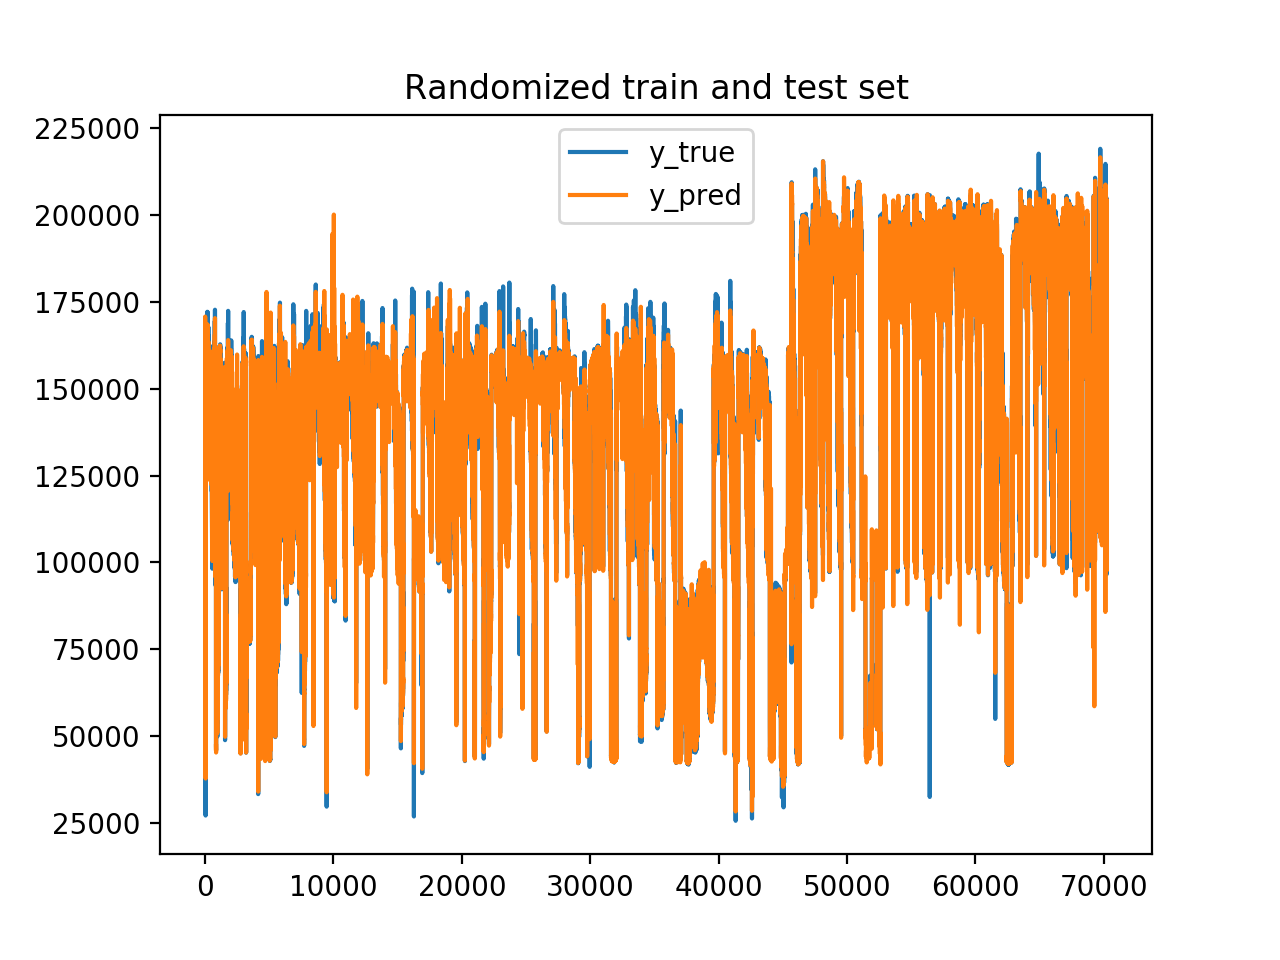

In [8]:
y_df = pd.DataFrame(np.concatenate((y.reshape((y.shape[0],1)), y_rf.reshape((y_rf.shape[0],1))), axis=1))
y_df.columns=['y_true', 'y_pred']
y_df.plot(title='Randomized train and test set')

<IPython.core.display.Javascript object>


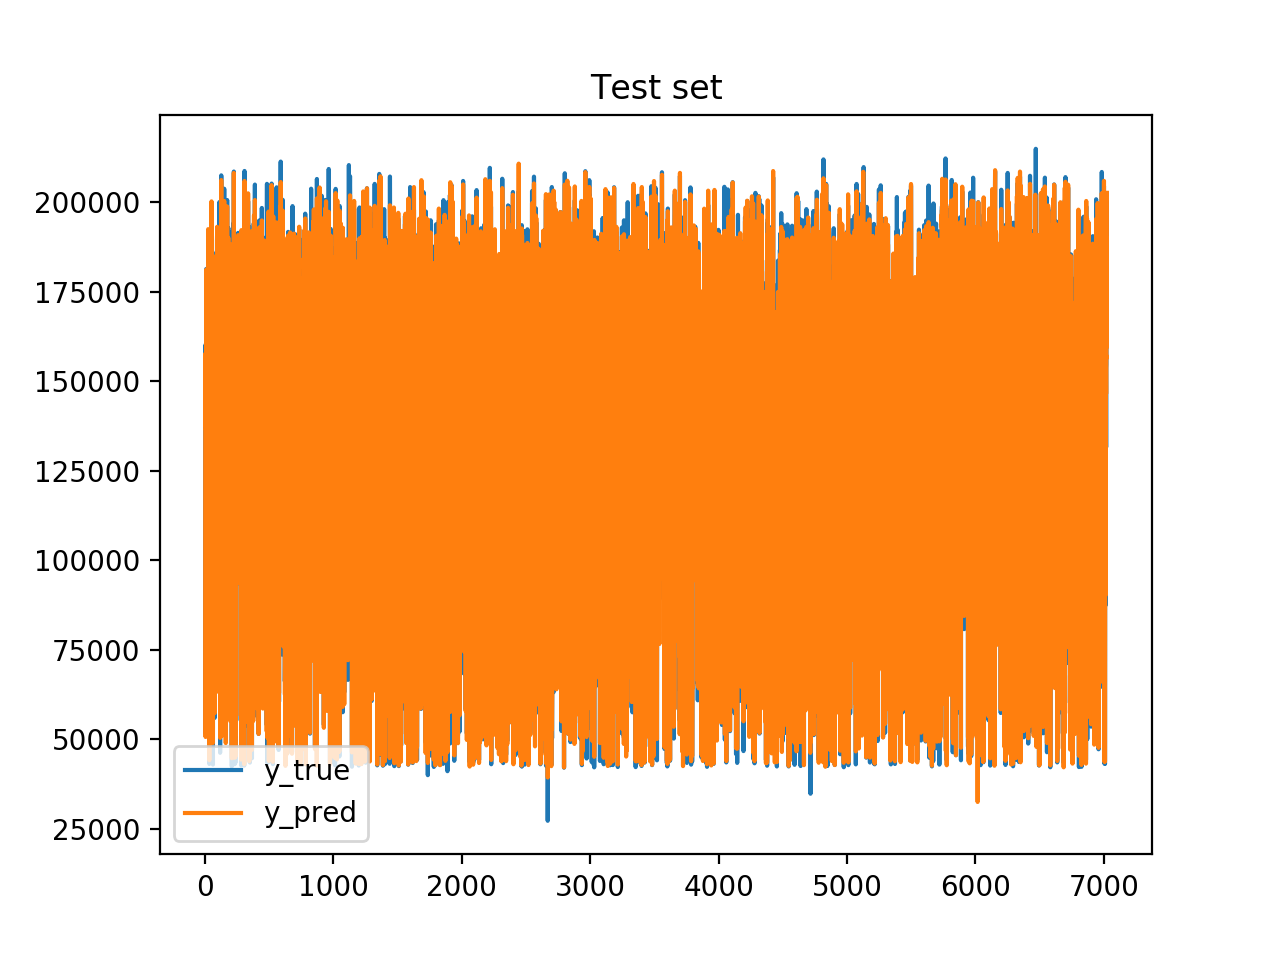

In [10]:
y_test_df = pd.DataFrame(np.concatenate((y_test.reshape((y_test.shape[0],1)), y_rf_test.reshape((y_rf_test.shape[0],1))), axis=1))
y_test_df.columns=['y_true', 'y_pred']
y_test_df.plot(title='Test set')

In [11]:
from sklearn.metrics import mean_absolute_error as mae
print(mae(y_test, y_rf_test))
y_test_df['absolute error'] = abs(y_test_df['y_true'] - y_test_df['y_pred'])
y_test_df['relative error'] = abs(y_test_df['y_true'] - y_test_df['y_pred'])/y_test_df['y_true']
y_test_df.head()
y_test_df.describe()

4924.67909668849


,y_true,y_pred,absolute error,relative error
count,7026.000000,7026.000000,7026.000000,7026.000000
mean,136977.609619,136977.867238,4924.679097,0.039220
std,41370.244008,40758.941091,6901.649360,0.058339
min,27171.000000,32433.500000,2.200000,0.000030
25%,105818.000000,107232.625000,1066.025000,0.008069
50%,152047.500000,151490.000000,2628.550000,0.019616
75%,161208.250000,159736.750000,5774.825000,0.045830
max,214935.000000,210792.500000,88733.700000,1.003167


In [12]:
# value1, evaflowRate, deltaT12, H
print(regr_rf.score(X_test,y_test))
regr_rf.feature_importances_

0.9579966096013504


array([0.04078677, 0.0195863 , 0.34177373, 0.59785321])

In [13]:
T1_min=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['min'])[0]
T1_max=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['max'])[0]
F_min=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['min'])[1]
F_max=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['max'])[1]
H_mean=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['H']].describe().loc['mean'])[0]
df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate','H']].describe()

,value1,evaflowRate,H
count,70255.000000,70255.000000,70255.000000
mean,8.584549,232.000196,638.730925
std,1.413967,3.363817,243.067214
min,0.000000,178.174408,-13454.889544
25%,7.686157,231.089134,539.247186
50%,8.401794,231.691666,684.866779
75%,9.309692,232.445282,752.142398
max,69.989324,509.306458,14201.987845


In [14]:
T1=np.arange(np.floor(T1_min), np.ceil(T1_max), 0.5)
F=np.arange(np.floor(F_min), np.ceil(F_max), 0.5)

In [17]:
#H is just deltaT12*F because optimizing ignores constants
H=H_mean
def COP(H,T1,F_full):
    n = len(T1)
    m = len(F_full)
    P_full=np.zeros((n,m))
    i=0
    for F in F_full:
        X=np.array([T1,F*np.ones(n),(H/F)*np.ones(n),H*np.ones(n)]).T
        P = regr_rf.predict(X)
        P_full[:,i]=P
        i+=1
    assert(P_full.shape == (n,m))
    return H/P_full,P_full
COP_T,P_T = COP(H,T1,F)

(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(140, 4)
(

<IPython.core.display.Javascript object>


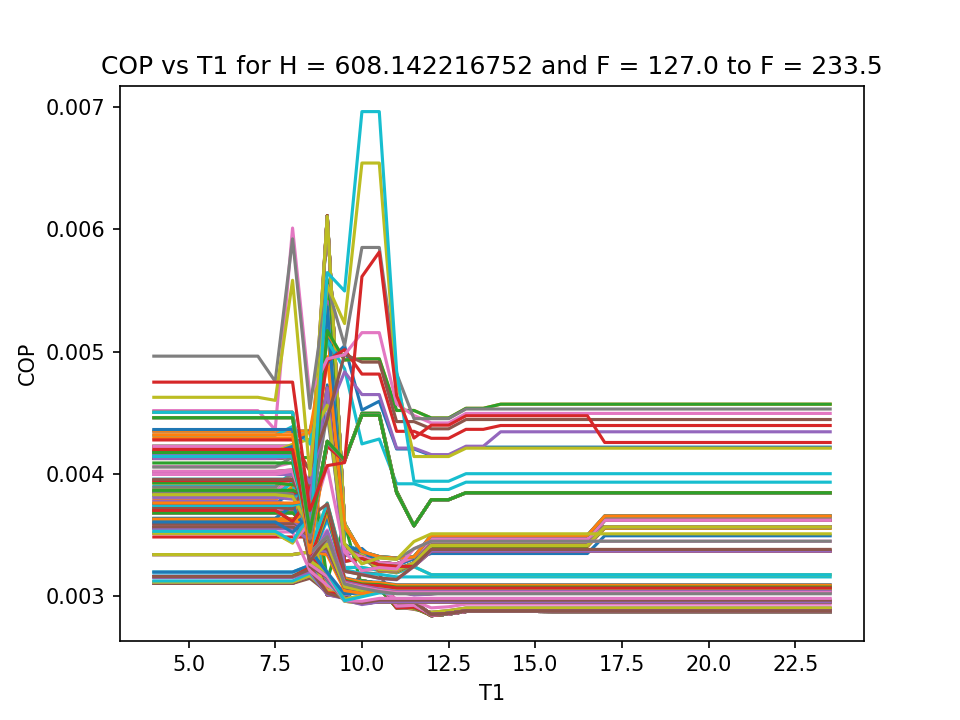

In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.title('COP vs T1 for H = '+str(H)+' and F = '+str(F[int(np.ceil(len(F)/2))]))
plt.title('COP vs T1 for H = '+str(H)+' and F = '+str(F[0])+' to F = '+str(F[-1]))
#plt.axvline(x=T1[np.argmax(COP_T)], color='r')
#plt.plot(T1,COP_T[:,int(np.ceil(len(F)/2))])
plt.plot(T1,COP_T)
plt.xlabel('T1')
plt.ylabel('COP')

<IPython.core.display.Javascript object>


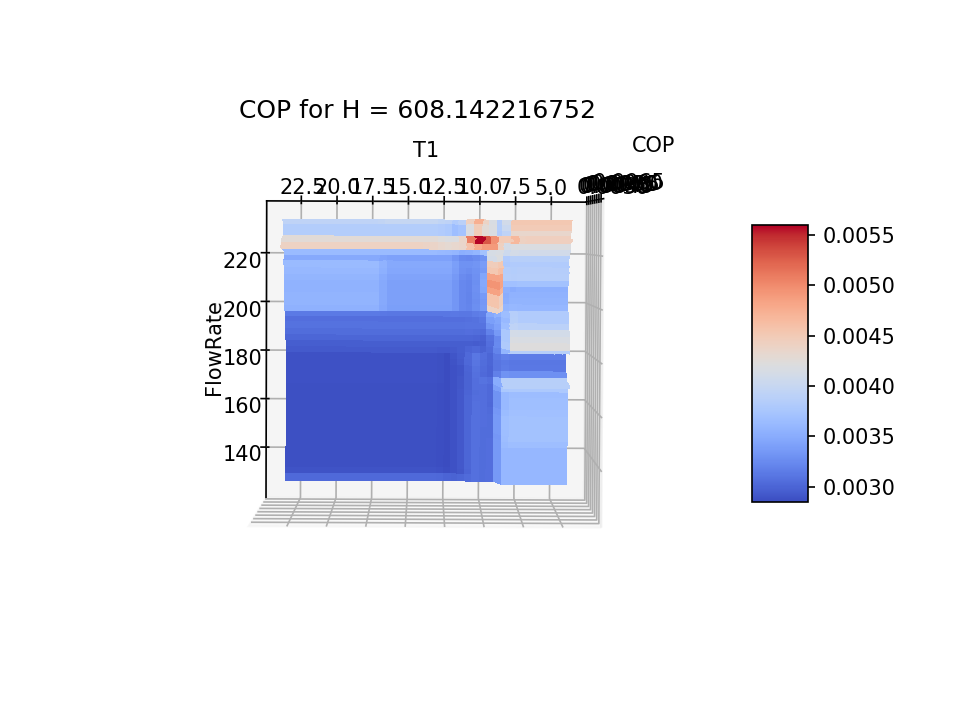

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
F_full=np.ones((len(T1),1)).dot(F.reshape(1,len(F)))
T1_full=np.ones((len(F),1)).dot(T1.reshape(1,len(T1))).T
surf=ax.plot_surface(F_full, T1_full, COP_T,cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf,shrink=0.5, aspect=5)
#surf=ax.plot_wireframe(F_full, T1_full, COP_T)
ax.set_xlabel('FlowRate')
ax.set_ylabel('T1')
ax.set_zlabel('COP')
ax.set_title('COP for H = '+str(H_mean))